# Εργαστηριακή Άσκηση 5
## QAM-PSK
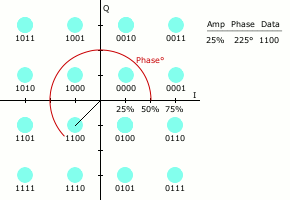

## Ερωτήσεις 
 <font size="3">1  ) Να σχεδιάσετε σηματικό αστερισμό 16-QAM πλήρους ορθογωνικού
 πλέγματος, με σημειωμένες τις δυαδικές λέξεις δίπλα σε κάθε σημείο του
 (όπως στο σχήμα 5.4(β) των σημειώσεων) με κωδικοποίηση Gray.</font>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.signal
from math import log
import array
from scipy.signal import upfirdn,decimate
from scipy.special import erfc

In [2]:
L = 4
M = 16
l = int(np.log2(L))

# Δημιουργούμε τα σημεία του αστερισμού στο διάνυσμα mapping, 
# έτσι ώστε να τηρείται κωδικοποίηση Gray
core = np.array([1+1j, 1-1j, -1+1j, -1-1j])
mapping = core

if (l > 1):
    for k in range (1,l):
        mapping = mapping + k*2*core[0]
        mapping = np.array([mapping, np.conj(mapping)])
        mapping = np.array([mapping, (-np.conj(mapping))])
        
mapping = mapping.flatten().T

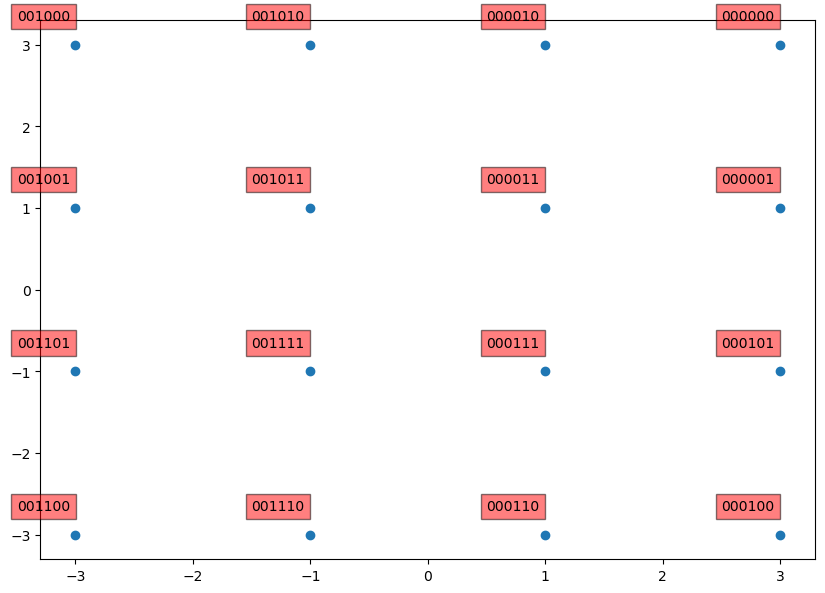

In [3]:
# Δημιουργούμε την κωδικοποίηση των σημειών του αστερισμού
# Η bin επιστρέφει strings της μορφής '0bxxx' - αποκόπτουμε τα δύο πρώτα bits του string
# και στην συνέχεια προσθέτουμε μηδενικά στα αριστερά, ώστε να έχουμε ετικέττες με sqrt(M) bits
# (M η τάξη της διαμόρφωσης)

labels = []
for i in range (0,L*L):
    labels.append(bin(i)[2:].zfill(6))

# Μετατοπίζουμε τις ετικέττες από τα σημεία του αστερισμού για καλύτερο οπτικό αποτέλεσμα
dx = -0.5
dy = 0.3

plt.figure(figsize=(10,7))
plt.scatter(mapping.real,mapping.imag)
for i in range (0,len(labels)):
    plt.text(mapping[i].real+dx, mapping[i].imag+dy, labels[i],bbox=dict(facecolor='red', alpha=0.5))
plt.show()

<font size="3"> 2)Έχουμε στη διάθεσή μας το ζωνοπερατό δίαυλο 6.75-9.25 MHz και θέλουμε να εκπέμψουμε με ρυθμό 12 Mbps. Να επιλεγεί σύστημα M-QAM πλήρους oρθογωνικού πλέγματος και σηματοδοσίας Nyquist, κατάλληλο για το
σκοπό αυτό. Επιλέξτε το μικρότερο δυνατό Μ και κατάλληλη τιμή roll-off ώστε να εκμεταλλευτείτε όλο το διαθέσιμο εύρος ζώνης. Εξομοιώστε πομπό και δέκτη και σχεδιάστε θεωρητικά και πειραματικά την καμπύλη
Pb<-->Eb/No. Η συχνότητα δειγματοληψίας πρέπει να είναι επαρκώς υψηλή, ώστε τα σήματα όλων των βαθμίδων διαμόρφωσηςαποδιαμόρφωσης να μπορούν να παρασταθούν χωρίς σφάλμα
αναδίπλωσης (alising).</font>
    
Σύνδεση με τη θεωρία: Ο ρυθμός μετάδοσης, R (bits/s), συνδέεται με το ρυθμό μετάδοσης συμβόλων ,1/Τ (baud rate) και το μέγεθος του σημαντικού αστερισμού με τη σχέση 
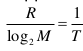
 Εξάλλου, το απαιτούμενο εύρος ζώνης για ζωνοπερατή μετάδοση με σηματοδοσία Nyquist, ισούται με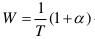
όπου α ο συντελεστής εξάπλωσης (roll-off Tfactor) του φίλτρου Nyquist. Από το συνδυασμό των παραπάνω σχέσεων, το μέγεθος του σηματικού αστερισμού θα πρέπει να ικανοποιεί τη σχέση 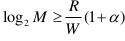
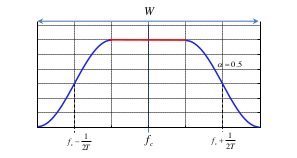

In [4]:
W=(9.25-6.75)*(10**6)
R=12*(10**6)
M=2**(R/W)
print(M)
M=64 #θέλουμε να είναι πλήρους ορθογωνικού πλέγματος οπότε επιλέγουμε αυτή την τιμή 
a=np.log2(M)*W/R-1
print(a) #roll-off



27.85761802547597
0.25


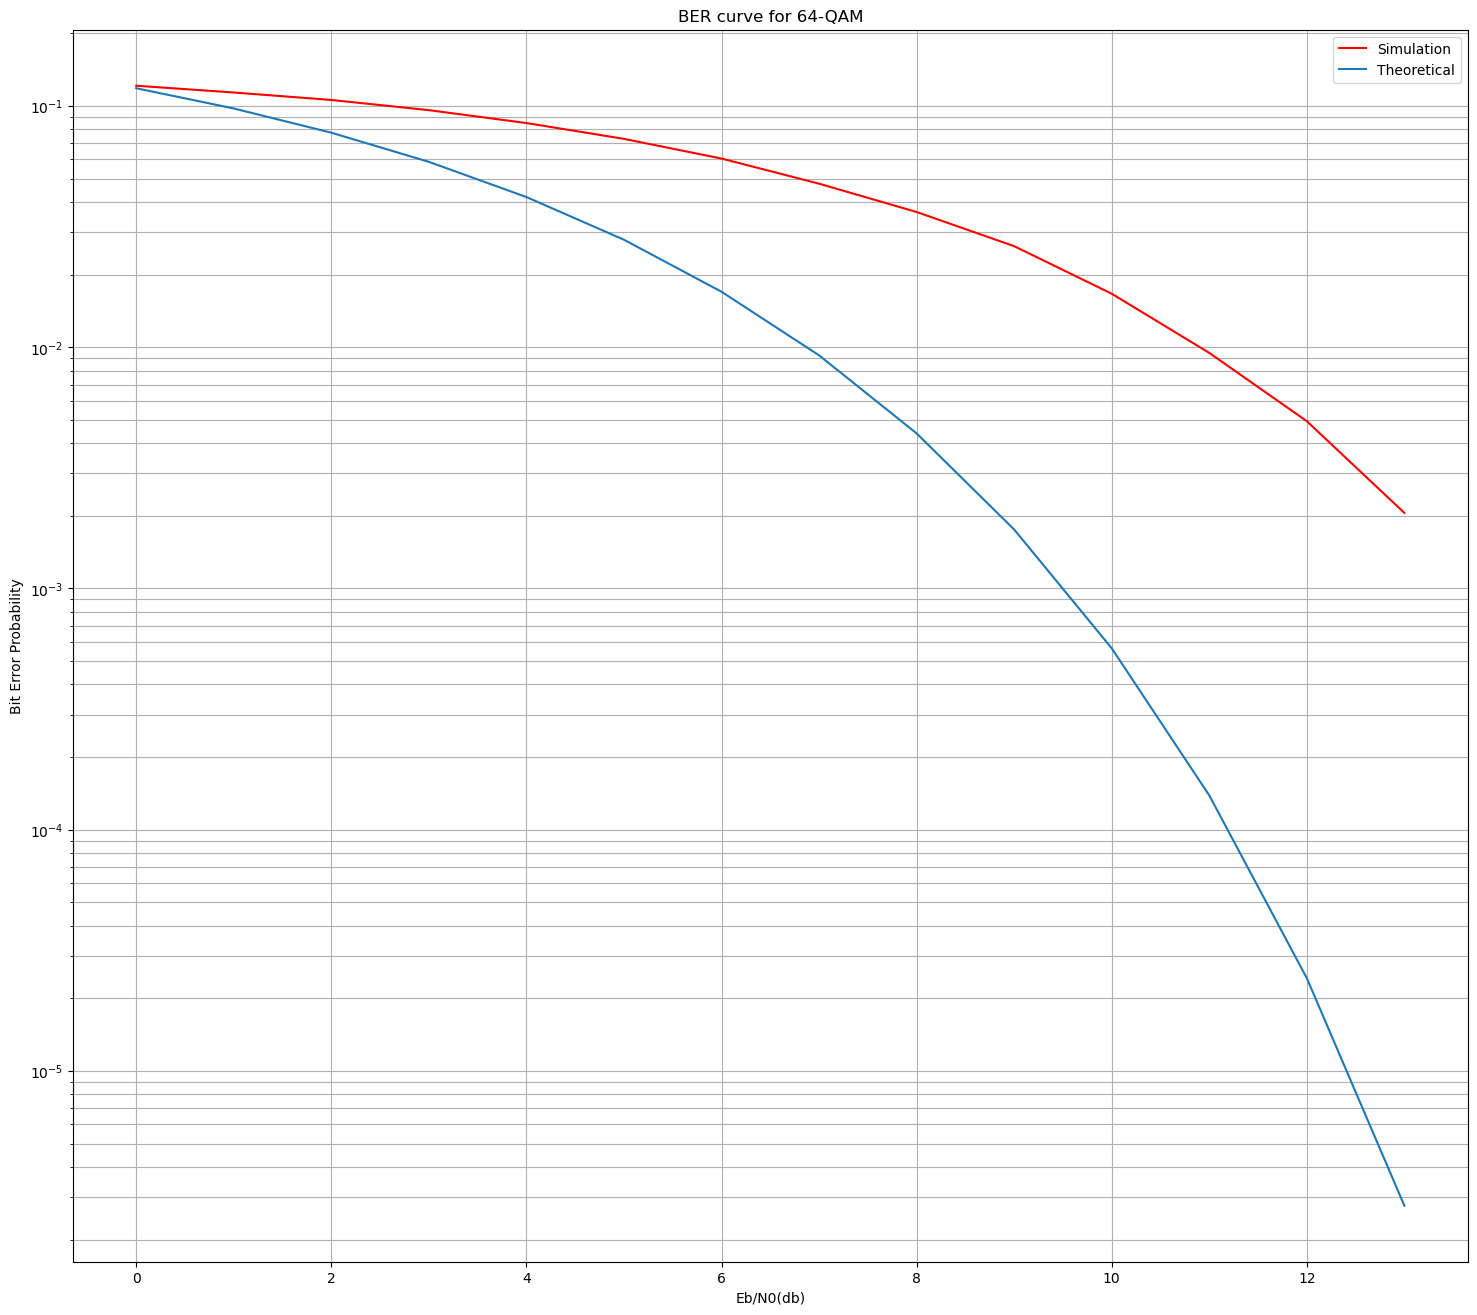

In [5]:
def rootRaisedCosine(nsamp, roll_off, delay):
    F0 = 0.5 / nsamp
    Fd = 1
    Fs = Fd * nsamp
    Td = 1 / Fd
    Ts = 1 / Fs
    F1 = F0 * (1 - roll_off)
    F2 = F0 * (1 + roll_off)
    filter_order = 2 * nsamp * delay

    t = np.arange(0, filter_order, Td)
    h = []
    for i in range(len(t)):
        t_shifted = t[i] - filter_order / 2
        if t_shifted == 0:
            h.append(np.sqrt(2 * F0) *(1 + roll_off * ((4 / np.pi) - 1)))
        elif t_shifted == 1 / 8 / roll_off / F0 or t_shifted == - 1 / 8 / roll_off / F0 :
            h.append((roll_off * np.sqrt(F0)) * ((1 + 2 / np.pi) * np.sin(np.pi / 4 / roll_off) + (1 - 2 / np.pi) * np.cos(np.pi / 4 / roll_off)))
        else:
            factor1 = np.sqrt(2 * F0) / (1 - 64 * roll_off* roll_off * F0 * F0 * t_shifted * t_shifted)
            factor2 = np.sin(2 * np.pi * F1 * t_shifted) / (2 * np.pi * F0 * t_shifted)
            factor3 = (4 * roll_off / np.pi) * np.cos(2 * np.pi * F2 * t_shifted) 
            h.append(factor1 * (factor2 + factor3))


  #  plt.plot(t,h)
   # plt.grid()
    #plt.show()
    
    return h

def ber_64qam(EbNo):
    a=0.25
    L=8
    l=np.log2(L)
    k=2*l
    M=64
    Nsymb=30000
    # προσομοίωση πομπού
    nsamp=16
    fc=4
    SNR=EbNo-10*np.log10(nsamp/k/2) #σε db
    core=[1+1j,1-1j,-1+1j,-1-1j]
    mapping=core[:]
    if(l>1):
        for j in range(1,int(l)):
            mapping=(list(map(lambda x:x+j*2*core[0],mapping)))
            conj_arr=np.conj(mapping)
            mapping= mapping + conj_arr.tolist()
            conj_arr=-np.conj(mapping)
            mapping= mapping + conj_arr.tolist()
            
    #παράγουμε τυχαία ακολουθία
    x=np.floor(2*np.random.rand(int(k*Nsymb),1))
    x_temp=np.reshape(x,(int(len(x)/(k)),int(k)))
    xsym=[]

    # χωρίζω τη λίστα σε επιμέρους λίστες και βάζω τα περιεχόμενα 
    #της καθεμίας σε ένα string ώστε με την εντολή int() να 
    # μετατραπεί από binary σε decimal
    for i in range(0,len(x_temp)):
        my_str=''
        y=x_temp[i]
        for j in range(0,int(np.log2(M))):
            my_str=my_str+str(int(y[j]))
        a=int(my_str, 2)
        xsym=xsym+[a]

    y=[]
    for n in range(0,len(xsym)):
        y=y + [mapping[xsym[n]]]
    
    delay=10
    filtorder= delay*nsamp*2
    rolloff=0.25

    shaping_filter=rootRaisedCosine(nsamp, rolloff, delay)
    ytx=upfirdn([1], y, nsamp) #upsample
    ytx=np.convolve(ytx,shaping_filter)
    m=np.arange(1,len(ytx)+1)
    s=np.real(np.multiply(ytx,np.exp(1j*2*np.pi*fc*m/nsamp)))
    
    s_matrix=np.matrix(s) #ανάστροφος
    s_matrix=s_matrix.getH()
    s_list=s_matrix.tolist()
    Ps=10*np.log10(np.matmul(s,s_list)/len(s)) #ισχύς μιγαδικού σήματος σε db
    Pn=Ps-SNR

    n=np.sqrt(10**(Pn/10))*np.random.randn(1,len(ytx))
    snoisy=s+n
    
    #δέκτης
    yrx=2*np.multiply(snoisy,np.exp(-1j*2*np.pi*fc*m/nsamp))
    yrx=yrx[0,:]
    yrx=np.convolve(yrx,shaping_filter)
    yrx=yrx[::nsamp] #downsample 
    
    yrx=yrx[2*delay+0:len(yrx)-2*delay]
    
    yi=yrx.copy()
    yq=np.imag(yi)
    yi=np.real(yi)
    
    xrx=[]
    q=np.arange(-L+1,L,2)

    for n in range(len(yrx)):
        differences = np.abs(q-yi[n]) # Πίνακας με τις διαφορές του σήματος από τα επίπεδα
        m = min(differences)
        [index], = np.where(differences == m)
        yi[n] = q[index]
        differences = np.abs(q-yq[n]) # Πίνακας με τις διαφορές του σήματος από τα επίπεδα
        m = min(differences)
        [index], = np.where(differences == m)
        yq[n] = q[index]
    error = 0
    for i in range(len(yrx)):
        if y[i] != yi[i]+yq[i]*1j:
            error += 1 
    return (error/len(x))
    
ber_exp=[]
ber_th=[]
for i in range(1,15):
    ber_exp=ber_exp+[ber_64qam(i)]
    ber_th = ber_th +[((L - 1) /(L*np.log2(L)) * scipy.special.erfc(np.sqrt(3 * np.log2(L) / (L * L - 1) * 10**(i/10))))]

plt.figure(figsize=(18, 16))
plt.semilogy(ber_exp,'r')
plt.semilogy(ber_th)
plt.legend(['Simulation', 'Theoretical'])
plt.xlabel('Eb/N0(db)')
plt.ylabel('Bit Error Probability')
plt.title('BER curve for 64-QAM')
plt.grid(which='both')
plt.show()

<font size="3">  3) Αν ο μέγιστος ανηγμένος σηματοθορυβικός λόγος, Eb/No, που μπορείτε να
πετύχετε στο δέκτη είναι 10 db και ο κωδικοποιητής διαύλου που έχετε στη
διάθεσή σας απαιτεί η πιθανότητα εσφαλμένου bit να μην υπερβαίνει την
τιμή 0.002, αναδιπλωθείτε σε σύστημα QAM μικρότερης τάξης, χωρίς να
αλλάξετε τις άλλες παραμέτρους σηματοδοσίας. Ποιός είναι τώρα ο
μέγιστος ρυθμός μετάδοσης; Σχεδιάστε και πάλι την πυκνότητα φάσματος
ισχύος των σημάτων σας και δείτε αν υπάρχουν διαφοροποιήσεις.</font>

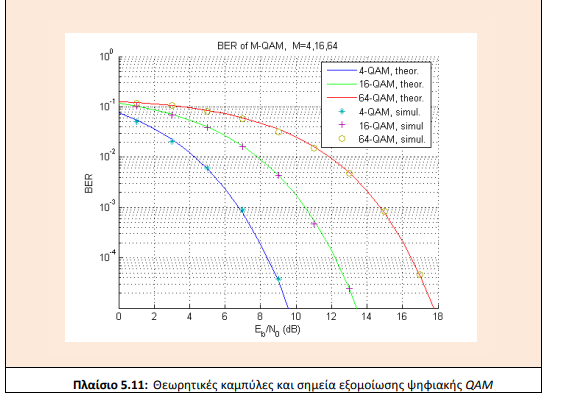

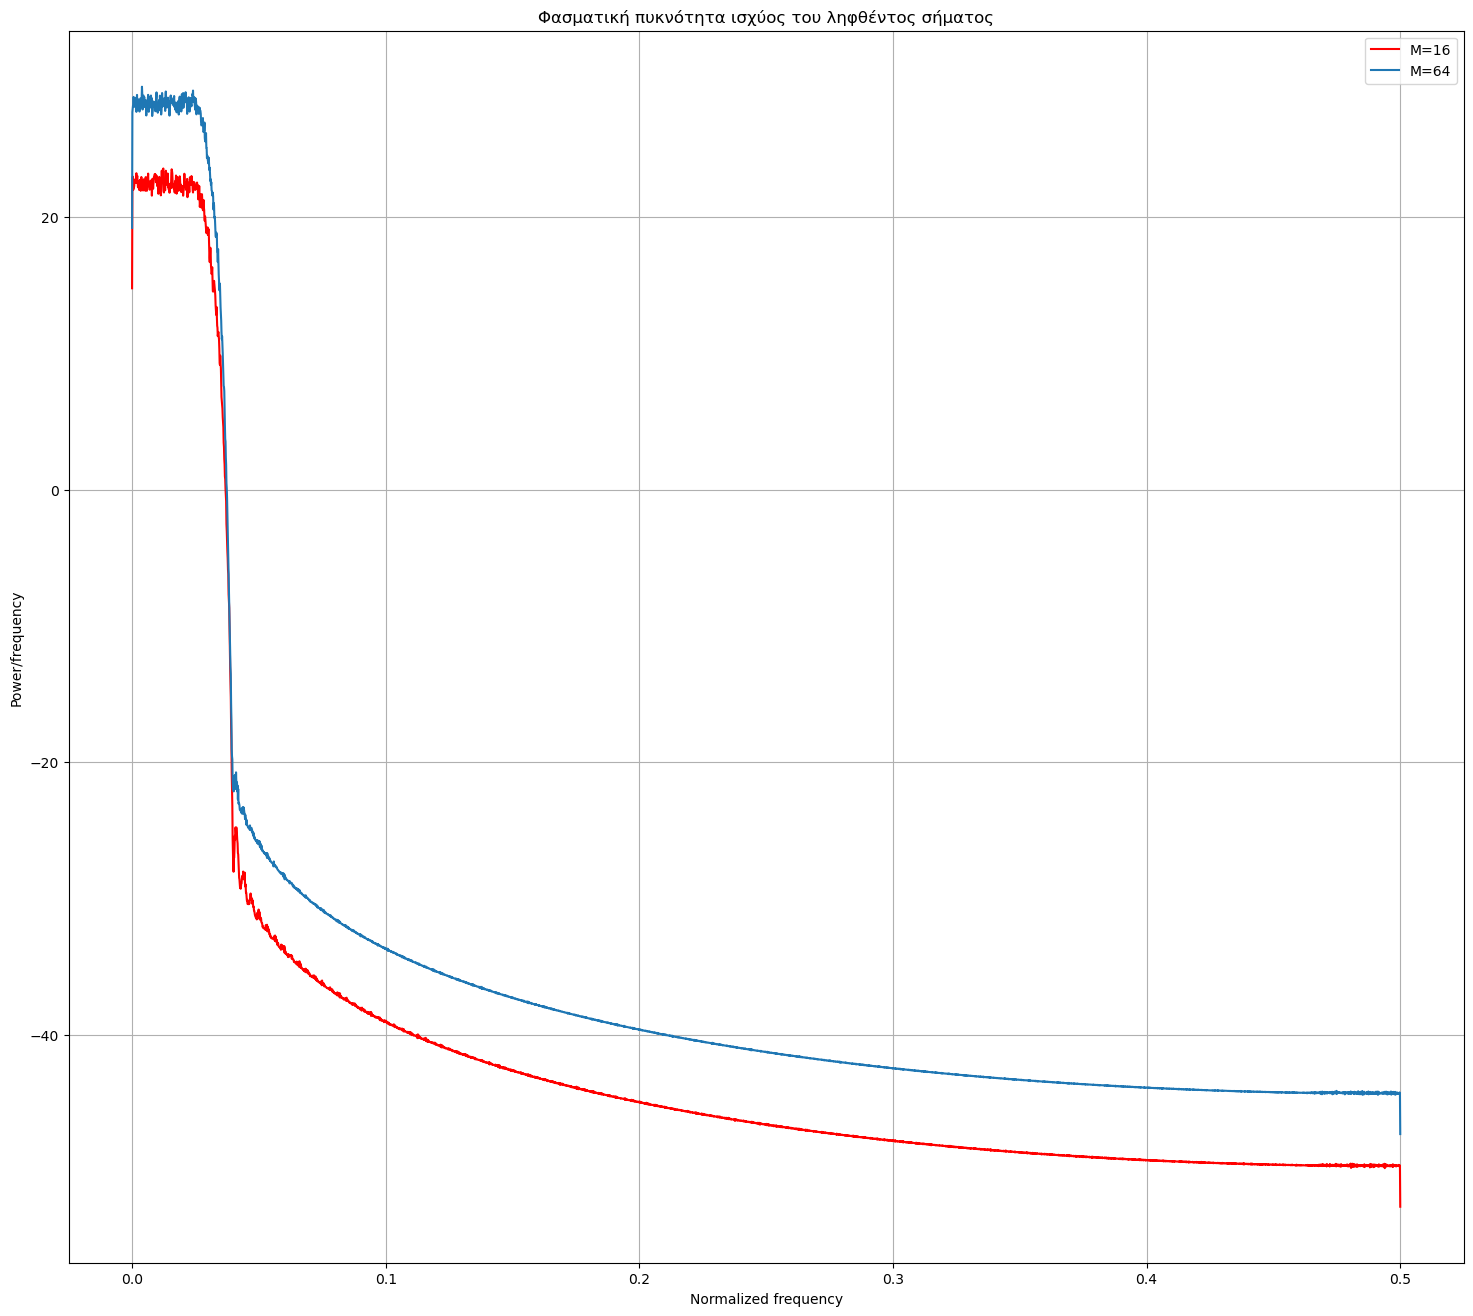

In [6]:
# για μέγιστο Eb/N0=10db και μέγιστο Pb=0.002 βρίσκουμε από το σχήμα 5.11 
# ότι το κατάλληλο σύστημα είναι αυτό για Μ=16
# ο μέγιστος ρυθμός απόδοσης είναι: R<=log2(M)*W/(1+a)=8Mbps


def MQAM(L):
    a=0.25
    l=np.log2(L)
    k=2*l
    M=L**2
    Nsymb=30000
    # προσομοίωση πομπού
    nsamp=16
    fc=4
    SNR=L-10*np.log10(nsamp/k/2) #σε db
    core=[1+1j,1-1j,-1+1j,-1-1j]
    mapping=core[:]
    if(l>1):
        for j in range(1,int(l)):
            mapping=(list(map(lambda x:x+j*2*core[0],mapping)))
            conj_arr=np.conj(mapping)
            mapping= mapping + conj_arr.tolist()
            conj_arr=-np.conj(mapping)
            mapping= mapping + conj_arr.tolist()

    #παράγουμε τυχαία ακολουθία
    x=np.floor(2*np.random.rand(int(k*Nsymb),1))
    x_temp=np.reshape(x,(int(len(x)/(k)),int(k)))
    xsym=[]

    # χωρίζω τη λίστα σε επιμέρους λίστες και βάζω τα περιεχόμενα 
    #της καθεμίας σε ένα string ώστε με την εντολή int() να 
    # μετατραπεί από binary σε decimal
    for i in range(0,len(x_temp)):
        my_str=''
        y=x_temp[i]
        for j in range(0,int(np.log2(M))):
            my_str=my_str+str(int(y[j]))
        a=int(my_str, 2)
        xsym=xsym+[a]

    y=[]
    for n in range(0,len(xsym)):
        y=y + [mapping[xsym[n]]]

    delay=10
    filtorder= delay*nsamp*2
    rolloff=0.25

    shaping_filter=rootRaisedCosine(nsamp, rolloff, delay)
    ytx=upfirdn([1], y, nsamp) #upsample
    ytx=np.convolve(ytx,shaping_filter)
    m=np.arange(1,len(ytx)+1)
    s=np.real(np.multiply(ytx,np.exp(1j*2*np.pi*fc*m/nsamp)))

    s_matrix=np.matrix(s) #ανάστροφος
    s_matrix=s_matrix.getH()
    s_list=s_matrix.tolist()
    Ps=10*np.log10(np.matmul(s,s_list)/len(s)) #ισχύς μιγαδικού σήματος σε db
    Pn=Ps-SNR

    n=np.sqrt(10**(Pn/10))*np.random.randn(1,len(ytx))
    snoisy=s+n

    #δέκτης
    yrx=2*np.multiply(snoisy,np.exp(-1j*2*np.pi*fc*m/nsamp))
    yrx=yrx[0,:]
    yrx=np.convolve(yrx,shaping_filter)
    f, Pxx_den = scipy.signal.welch(np.real(yrx), window='hamming', nperseg=8196)
    return f,Pxx_den

# Υπολογίζουμε την φασματική πυκνότητα ισχύος του ληφθέντος σήματος
f,Pxx_den=MQAM(4)
Pxx_den = 10 * np.log10(Pxx_den)
fig = plt.figure(figsize=(18, 16))
plt.plot(f, Pxx_den,'r')
f,Pxx_den=MQAM(8)
Pxx_den = 10 * np.log10(Pxx_den)
plt.plot(f, Pxx_den)
plt.grid()
plt.title('Φασματική πυκνότητα ισχύος του ληφθέντος σήματος')
plt.xlabel('Normalized frequency')
plt.ylabel('Power/frequency')
plt.legend(['Μ=16', 'Μ=64'])
plt.show()


<font size="3">4. Πόσο μπορεί να αυξηθεί ο ρυθμός μετάδοσης στο ερώτημα 3, αν μπορεί να
μειωθεί στο μισό του το roll-off του φίλτρου Nyquist;</font>

In [7]:
#Για 64-QAM  M=64
W=(9.25-6.75)*(10**6)
a=0.125 # μειωθεί στο μισό του το roll-off του φίλτρου Nyquist
R=W*np.log2(64)/(1+a)
print("Nέος ρυθμός μετάδοσης" ,R/(10**6),"Mbps")


Nέος ρυθμός μετάδοσης 13.333333333333334 Mbps
